Imports

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re
import seaborn as sns


In [ ]:
def load_credit_cards():
    filename = "data/credit_cards.xlsx"
    excel = pd.ExcelFile(filename)

    df1 = pd.read_excel(excel, sheet_name='Sheet1', skiprows=[r for r in range(15)] + [16],usecols=lambda x: 'Unnamed' not in x)
    df2 = pd.read_excel(excel, sheet_name='Sheet2', skiprows=[r for r in range(10)] + [11],usecols=lambda x: 'Unnamed' not in x)

    rendict = {
        'BALANCE.1':'BALANCE_FREQ', 'PURCHASES.1':'PURCHASES_FREQ', 'ONEOFF_PURCHASES.1':'ONEOFF_PURCHASES_FREQ',
       'PURCHASES_INSTALLMENTS':'PURCHASES_INSTALLMENTS_FREQ', 'CASH_ADVANCE.1':'CASH_ADVANCE_FREQ'
    }

    df = pd.concat([df1, df2], ignore_index=True)

    df = df.rename(columns=rendict)

    return df

In [ ]:
df = load_credit_cards()
print(len(df)) # pocet zaznamu
df[-df['CUST_ID'].notna()] # jestli funkce nenabrala prazdne radky


In [ ]:
cust = df['CUST_ID']
print(cust.nunique()) #some values of cust_id repete
value_counts = cust.value_counts()
repeated_values = value_counts[value_counts > 1]
print(all(repeated_values == 2)) # nejvyse dvakrat



In [ ]:
df = df.sort_values(by='CUST_ID')
print(df.head(15)) # vypada to, ze radky s duplicitnim id jsou cele stejne



In [ ]:
df = df.drop_duplicates()
len(df) # je tomu tak

In [ ]:
print(df.describe())


In [ ]:
df.columns

In [ ]:
correlation_matrix = df.dropna().drop(columns=['CUST_ID']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
sns.pairplot(df)

In [ ]:
sns.pairplot(df[['BALANCE', 'CREDIT_LIMIT']])

In [ ]:
sns.pairplot(df[['PAYMENTS', 'CREDIT_LIMIT']])

In [ ]:
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Check if the column is numeric
        plt.figure(figsize=(8, 6))
        df[column].hist(bins=100)
        plt.title(f'{column}')
        plt.xlabel(column)
        plt.grid(False)
        plt.show()

Většina množstevních veličin má asi exponenciální rozdělení.
Jde vidět, že frekvence jsou částečně zaokrouhlované, stejně tak card limit má obvykle kulatá čísla.
TENURE bychom mohli brát jako kategoriální (něco jako typ produktu) ale můžeme také využít přirozeného uspořádání (doby trvání produktu)

Dalo by se trénovat model který předpoví tenure nejvhodnější prozákazníka. Bude to ale možná složité, protože převažuje možnost 12.

Primárním cílem bude asi clusterování zákazníků do skupin.

In [ ]:
print((df['BALANCE'] == 0).sum())
print((df['BALANCE'] == -1).sum()) # jeden účet má balance -1


In [ ]:
df[df.eq(-1).any(axis=1)]

In [ ]:
df_something_missing = df[df.eq(-1).any(axis=1) | -df.notna().all(axis=1)]
df_something_missing


In [ ]:
df['MINIMUM_PAYMENTS'].isna().sum() # má nejvíc nan hodnot

In [ ]:
a = df[-df['MINIMUM_PAYMENTS'].isna()]
print(len(a[a.isna().any(axis=1)])) # cca 100 nan hodnot

print(len(df[df.eq(-1).any(axis=1)])) # cca 10 -1

print(len(df[df.eq(1.5).any(axis=1)]))



In [ ]:
# test jestli souhrnná tabulka nahoře excelu sedí (na všech 9000 záznamů)
df[['BALANCE', 'TENURE']].groupby('TENURE').sum().round()

# zřejmě je v ezcelu součet pouze první ho listu

In [ ]:
len(df[df['TENURE']==12]) / len(df)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

pca_transformer = PCA()

pca_pipeline = make_pipeline(
        MinMaxScaler(),
        pca_transformer,
)


missing_removed = df[-df.eq(-1).any(axis=1) & df.notna().all(axis=1)]
train = missing_removed.drop(columns=["CUST_ID"])


pca = pca_pipeline.fit_transform(train)
pca = pd.DataFrame(pca)
# pca.head()



In [ ]:
print(np.round(pca_transformer.components_[0:2],3))
np.round(pca_transformer.explained_variance_,4)

In [ ]:
ax = sns.scatterplot(
    data=pca,
    x=0,
    y=1,
    # hue=clusters,
    palette="muted",
    legend=False,
)

In [ ]:
from functions.plot_clusters import plot_clusters
from sklearn.cluster import KMeans


pca and clustering using minmax scaler (clustering before pca transform)


<Axes: xlabel='x', ylabel='y'>

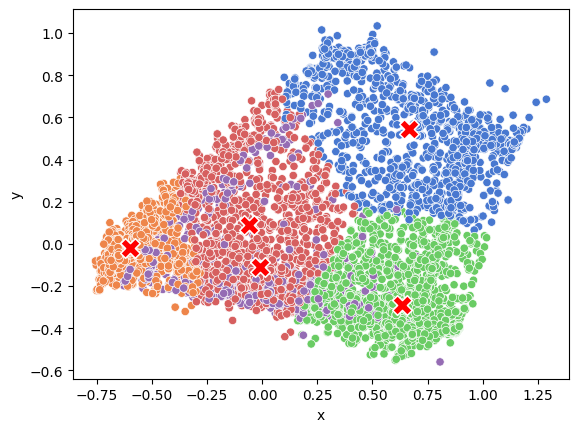

In [68]:

# set random state
kmeans = KMeans(n_clusters=5, random_state=5, n_init=1)

KMeans_pipeline = make_pipeline(
    MinMaxScaler(),
    kmeans,
)

clusters = KMeans_pipeline.fit_predict(train)

plt_data = pca[[0,1]].rename(mapper={0:'x', 1:'y'}, axis=1)
p = plot_clusters(plt_data, clusters)

# untransformed_centroids = kmeans.cluster_centers_
# M = pca_transformer.components_[0:2, :]
# centroids = np.dot(untransformed_centroids,M.T)
# centroids

centroids = pca_transformer.transform(kmeans.cluster_centers_)

# plot centroids
sns.scatterplot(
    x=centroids[:, 0],
    y=centroids[:, 1],
    marker="X",
    color="r",
    s=200,
)






pca and clustering scaling to variance = 1

In [69]:
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(
        StandardScaler(),
        pca_transformer,
)


pca = pca_pipeline.fit_transform(train)
pca = pd.DataFrame(pca)


<Axes: xlabel='x', ylabel='y'>

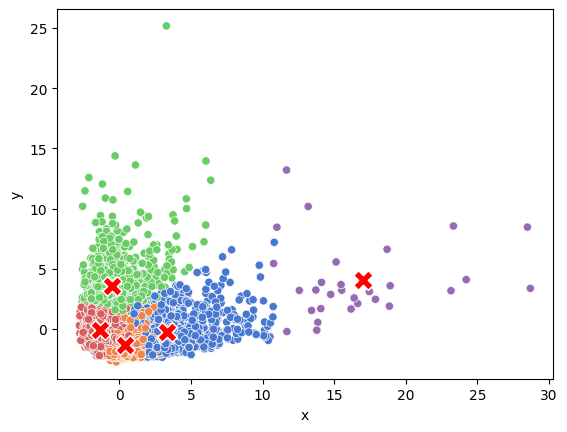

In [70]:
kmeans = KMeans(n_clusters=5, random_state=5, n_init=1)

KMeans_pipeline = make_pipeline(
    StandardScaler(),
    kmeans,
)

clusters = KMeans_pipeline.fit_predict(train)

plt_data = pca[[0,1]].rename(mapper={0:'x', 1:'y'}, axis=1)
p = plot_clusters(plt_data, clusters)

centroids = pca_transformer.transform(kmeans.cluster_centers_)

# plot centroids
sns.scatterplot(
    x=centroids[:, 0],
    y=centroids[:, 1],
    marker="X",
    color="r",
    s=200,
)